# Loss Landscape (TensorFlow v2)

*2024-05-29*

References:
- <http://mathformachines.com/posts/visualizing-the-loss-landscape>
- <http://arxiv.org/abs/1712.09913>
- <http://github.com/tomgoldstein/loss-landscape>
- <http://www.telesens.co/loss-landscape-viz/viewer.html>
- <http://www.telesens.co/2019/01/16/neural-network-loss-visualization>
- <http://github.com/marcellodebernardi/loss-landscapes>

In [101]:
%env TF_CPP_MIN_LOG_LEVEL=3
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers
from sklearn.decomposition import PCA

env: TF_CPP_MIN_LOG_LEVEL=3


In [102]:
class RandomCoordinates(object):

    def __init__(self, origin):
        self.origin_ = origin
        self.v0_ = normalize_weights(
            [np.random.normal(size=w.shape) for w in origin], origin)
        self.v1_ = normalize_weights(
            [np.random.normal(size=w.shape) for w in origin], origin)

    def __call__(self, a, b):
        return [
            a * w0 + b * w1 + wc
            for w0, w1, wc in zip(self.v0_, self.v1_, self.origin_)
        ]


def normalize_weights(weights, origin):
    return [
        w * np.linalg.norm(wc) / np.linalg.norm(w)
        for w, wc in zip(weights, origin)
    ]


class LossSurface(object):

    def __init__(self, model, inputs, outputs):
        self.model_ = model
        self.inputs_ = inputs
        self.outputs_ = outputs

    def compile(self, range, points, coords):
        a_grid = tf.linspace(-1.0, 1.0, num=points)**3 * range
        b_grid = tf.linspace(-1.0, 1.0, num=points)**3 * range
        loss_grid = np.empty([len(a_grid), len(b_grid)])
        for i, a in enumerate(a_grid):
            for j, b in enumerate(b_grid):
                self.model_.set_weights(coords(a, b))
                loss = self.model_.test_on_batch(self.inputs_,
                                                 self.outputs_,
                                                 return_dict=True)["loss"]
                loss_grid[j, i] = loss
        self.model_.set_weights(coords.origin_)
        self.a_grid_ = a_grid
        self.b_grid_ = b_grid
        self.loss_grid_ = loss_grid

    def plot(self, range=1.0, points=24, levels=20, ax=None, **kwargs):
        xs = self.a_grid_
        ys = self.b_grid_
        zs = self.loss_grid_
        if ax is None:
            _, ax = plt.subplots(**kwargs)
            ax.set_title("The Loss Surface")
            ax.set_aspect("equal")
        # Set Levels
        min_loss = zs.min()
        max_loss = zs.max()
        levels = tf.exp(
            tf.linspace(tf.math.log(min_loss),
                        tf.math.log(max_loss),
                        num=levels))
        # Create Contour Plot
        CS = ax.contour(xs,
                        ys,
                        zs,
                        levels=levels,
                        cmap="magma",
                        linewidths=0.75,
                        norm=mpl.colors.LogNorm(vmin=min_loss,
                                                vmax=max_loss * 2.0))
        ax.clabel(CS, inline=True, fontsize=8, fmt="%1.2f")
        return ax

In [103]:
NUM_EXAMPLES = 256
BATCH_SIZE = 64
SEED = 1

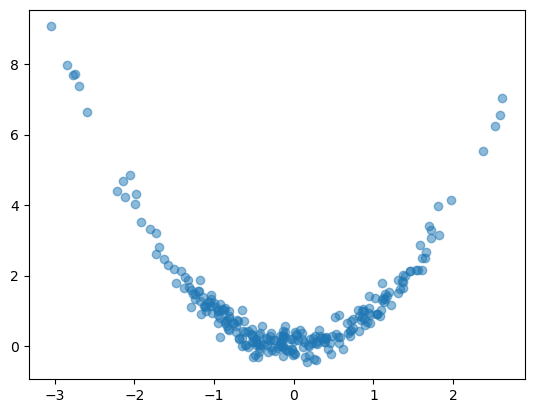

In [104]:
x = tf.random.normal(shape=(NUM_EXAMPLES, 1), seed=SEED)
err = tf.random.normal(shape=x.shape, stddev=0.25, seed=SEED)
y = x**2 + err
y = tf.squeeze(y)
ds = (tf.data.Dataset.from_tensor_slices(
    (x, y)).shuffle(NUM_EXAMPLES).batch(BATCH_SIZE))
plt.plot(x, y, 'o', alpha=0.5)
plt.show()

94/94 [==============================] - 0s 1ms/step


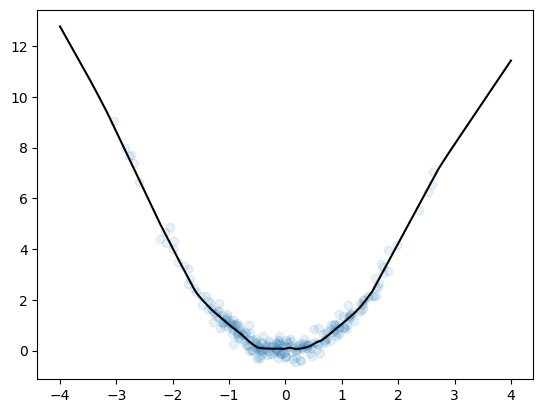

In [105]:
model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(loss='mse', optimizer='adam')
history = model.fit(ds, epochs=200, verbose=0)

# Look at fitted curve
grid = tf.linspace(-4, 4, 3000)
fig, ax = plt.subplots()
ax.plot(x, y, 'o', alpha=0.1)
ax.plot(grid, model.predict(grid).reshape(-1, 1), color='k')
plt.show()

<Figure size 640x480 with 0 Axes>

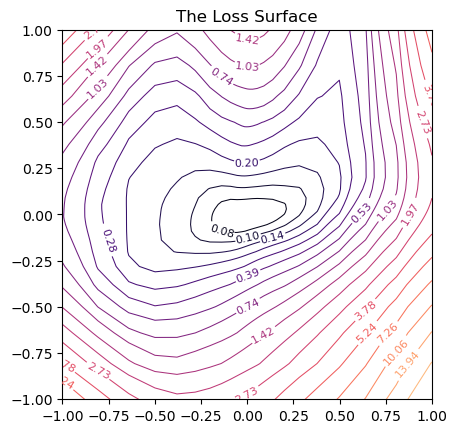

In [106]:
coords = RandomCoordinates(model.get_weights())
loss_surface = LossSurface(model, x, y)
loss_surface.compile(points=30, coords=coords, range=1.0)

plt.figure(dpi=100)
loss_surface.plot()
plt.show()

Principal Component Analysis (PCA) - Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html



In [107]:
# Some utility functions to reshape network weights
def vectorize_weights_(weights):
    vec = [w.flatten() for w in weights]
    vec = np.hstack(vec)
    return vec


def vectorize_weight_list_(weight_list):
    vec_list = []
    for weights in weight_list:
        vec_list.append(vectorize_weights_(weights))
    weight_matrix = np.column_stack(vec_list)
    return weight_matrix


def shape_weight_matrix_like_(weight_matrix, example):
    weight_vecs = np.hsplit(weight_matrix, weight_matrix.shape[1])
    sizes = [v.size for v in example]
    shapes = [v.shape for v in example]
    weight_list = []
    for net_weights in weight_vecs:
        vs = np.split(net_weights, np.cumsum(sizes))[:-1]
        vs = [v.reshape(s) for v, s in zip(vs, shapes)]
        weight_list.append(vs)
    return weight_list


def get_path_components_(training_path, n_components=2):
    # Vectorize network weights
    weight_matrix = vectorize_weight_list_(training_path)
    # Create components
    pca = PCA(n_components=2, whiten=True)
    components = pca.fit_transform(weight_matrix)
    # Reshape to fit network
    example = training_path[0]
    weight_list = shape_weight_matrix_like_(components, example)
    return pca, weight_list


class PCACoordinates(object):

    def __init__(self, training_path):
        origin = training_path[-1]
        self.pca_, self.components = get_path_components_(training_path)
        self.set_origin(origin)

    def __call__(self, a, b):
        return [
            a * w0 + b * w1 + wc
            for w0, w1, wc in zip(self.v0_, self.v1_, self.origin_)
        ]

    def set_origin(self, origin, renorm=True):
        self.origin_ = origin
        if renorm:
            self.v0_ = normalize_weights(self.components[0], origin)
            self.v1_ = normalize_weights(self.components[1], origin)

In [108]:
# Define Model
model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=[1]),
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse")

training_path = [model.get_weights()]
# Callback to collect weights as the model trains
collect_weights = callbacks.LambdaCallback(on_epoch_end=(
    lambda batch, logs: training_path.append(model.get_weights())))

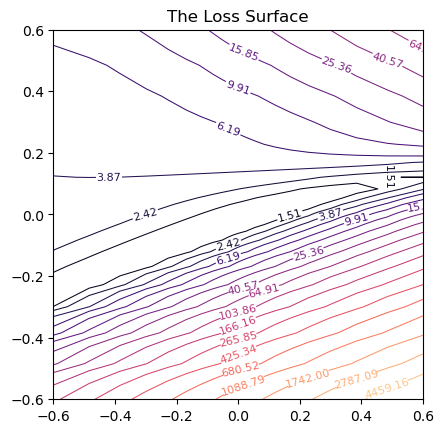

In [109]:
# Create data
ds = (tf.data.Dataset.from_tensor_slices(
    (x, y)).repeat().shuffle(1000, seed=SEED).batch(BATCH_SIZE))

history = model.fit(ds,
                    steps_per_epoch=1,
                    epochs=40,
                    callbacks=[collect_weights],
                    verbose=0)

# Create loss surface
coords = PCACoordinates(training_path)
loss_surface = LossSurface(model, x, y)
loss_surface.compile(points=30, coords=coords, range=0.6)
# Look at loss surface
loss_surface.plot(dpi=100)
plt.show()

In [110]:
def weights_to_coordinates(coords, training_path):
    components = [coords.v0_, coords.v1_]
    comp_matrix = vectorize_weight_list_(components)
    # the pseudoinverse
    comp_matrix_i = np.linalg.pinv(comp_matrix)
    # the origin vector
    w_c = vectorize_weights_(training_path[-1])
    # center the weights on the training path and project onto components
    coord_path = np.array([
        comp_matrix_i @ (vectorize_weights_(weights) - w_c)
        for weights in training_path
    ])
    return coord_path


def plot_training_path(coords, training_path, ax=None, end=None, **kwargs):
    path = weights_to_coordinates(coords, training_path)
    if ax is None:
        fig, ax = plt.subplots(**kwargs)
    colors = range(path.shape[0])
    end = path.shape[0] if end is None else end
    norm = plt.Normalize(0, end)
    ax.scatter(path[:, 0], path[:, 1], s=4, c=colors, cmap="cividis", norm=norm)
    return ax

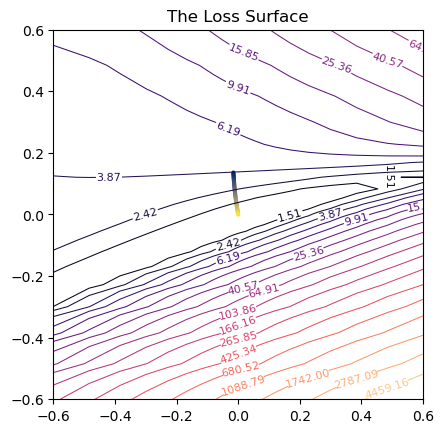

In [111]:
pcoords = PCACoordinates(training_path)
loss_surface = LossSurface(model, x, y)
loss_surface.compile(points=30, coords=pcoords, range=0.6)
ax = loss_surface.plot(dpi=100)
plot_training_path(pcoords, training_path, ax)
plt.show()